import:

In [542]:
# import these:
import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv
from wrappers.swingup_wrapper import SwingUpWrapper
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

function for making vectorized environments:

In [543]:
# function that takes seed and env_name:
def make_env(env_name : str, seed):
    def intermediary():
        # make the environment based on the provided env_name:
        env = gym.make(env_name)

        # wrap environment:
        env = SwingUpWrapper(env)

        # reset and seed the environment:
        env.reset(seed = seed)

        # return env to user:
        return env
    return intermediary

function for making keras models:

In [544]:
# function for making a keras model based on inputs:
def make_model(layers, neurons, rate, input_shape, output_shape, loss_function, output_activation):
    # instantiate model:
    model = keras.Sequential()

    # add hidden layers:
    for i in range(layers):
        if i == 0:
            model.add(Input(shape = (input_shape, )))
            model.add(Dense(neurons, activation = 'relu', name = f"hidden_layer_{i+1}"))
        else: 
            model.add(Dense(neurons, activation = 'relu', name = f"hidden_layer_{i+1}"))

    # add output layer:
    model.add(Dense(output_shape, activation = output_activation, name = 'output_layer'))

    # compile the model:
    model.compile(optimizer = Adam(learning_rate = rate),
                  loss = loss_function)
    
    # return to user:
    return model

function to calculate discounted returns in the vectorized environments:

In [545]:
def discounted_returns(rewards, dones, last_value, gamma : float):
    # compute the discounted cummulative reward for a vectorized environment:
    n_steps, n_envs = rewards.shape
    returns = np.zeros((n_steps, n_envs))
    running_return = last_value

    # start computing discounted return:
    for t in reversed(range(n_steps)):
        running_return = rewards[t] + gamma * running_return * (1 - dones[t])
        returns[t] = running_return
    
    # return to user:
    return returns

define parallelization stuff:

In [546]:
# define desired number of environments:
n_envs = 32

# make those environments:
envs = AsyncVectorEnv([make_env(env_name = "CartPole-v1", seed = i) for i in range(n_envs)])

# get information about state and action space:
nS = envs.single_observation_space.shape[0]
nA = envs.single_action_space.n

print(f"observation space has size: {nS}")
print(f"action space has size: {nA}")


observation space has size: 4
action space has size: 2


create networks:

In [547]:
# clear the backend:
tf.keras.backend.clear_session()

# model params:
layers = 3
neurons = 64
lr_a = 1e-4
lr_c = 1e-3
gamma = 0.98

# actor network with probabilistic output:
actor = make_model(layers = layers, neurons = neurons, rate = lr_a, input_shape = nS, output_shape = nA, output_activation = "softmax", loss_function = "categorical_crossentropy")

# critic network with linearly activated output:
critic = make_model(layers = layers, neurons = neurons, rate = lr_c, input_shape = nS, output_shape = 1, output_activation = "linear", loss_function = "mse")

function to perform the training step:

In [548]:
# decorated function for training:
@tf.function
def training_step(states, actions, returns, advantages):
    # convert these values to tensors:
    states = tf.convert_to_tensor(states, dtype = tf.float32)
    actions = tf.cast(actions, dtype = tf.int32)
    returns = tf.cast(returns, dtype = tf.float32)
    advantages = tf.cast(advantages, dtype = tf.float32)

    # CRITIC UPDATE:
    with tf.GradientTape() as critic_tape:
        # pass state through critic:
        values = tf.squeeze(critic(states, training = True), axis = 1)

        # compute critic loss:
        critic_loss = tf.reduce_mean(tf.square(returns - values))

    # backpropagate and update critic:
    critic_grads = critic_tape.gradient(critic_loss, critic.trainable_variables)
    critic.optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))

    # ACTOR UPDATE:
    with tf.GradientTape() as actor_tape:
        # pass state through actor to get probs:
        probabilities = actor(states, training = True)

        # take a log of policy for scoring:
        log_probs = tf.math.log(tf.clip_by_value(probabilities, 1e-8, 1.0))

        # get a mask of the actions chosen:
        action_mask = tf.one_hot(actions, nA, dtype = tf.float32)

        # get the log probability of the actions that were actually chosen:
        log_probs_chosen = tf.reduce_sum(action_mask * log_probs, axis = 1)

        # entropy term:
        entropy_per_sample = -tf.reduce_sum(probabilities * log_probs, axis = 1)

        # compute the actor loss (ascent):
        actor_loss = -tf.reduce_mean(log_probs_chosen * advantages) - beta * tf.reduce_mean(entropy_per_sample)
    
    # backpropagate and update actor:
    actor_grads = actor_tape.gradient(actor_loss, actor.trainable_variables)
    actor.optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))


training loop:

In [549]:
# define values:
n_steps = 40
num_updates = 10000
beta = 1e-1

per_env_reward = np.zeros(n_envs)
reward_history = []

obs, _ = envs.reset()

# training algorithm:
for update in tqdm(range(num_updates), colour = "#33FF00", ncols = 100, desc = "training progress:"):
    # 0) initialization:
    obs_buf = []
    act_buf = []
    rew_buf = []
    val_buf = []
    done_buf = []

    # 1) rollout for n_steps:
    for step in range(n_steps):
        # a) pass observation through networks:
        obs_tensor = tf.convert_to_tensor(obs, dtype = tf.float32)
        actor_output = actor(obs_tensor)
        critic_output = critic(obs_tensor)

        # b) pick an action:
        probs = actor_output.numpy()
        probs /= probs.sum(axis =1, keepdims = True)
        actions = [np.random.choice(len(prob), p = prob) for prob in probs]

        # c) step the environments:
        next_obs, rewards, terms, truncs, _ = envs.step(actions)
        per_env_reward += rewards
        done = np.logical_or(terms, truncs)

        # d) record finished episodes, reset those env returns:
        finished_indexes = np.where(done)[0]
        for i in finished_indexes:
            # append the per_env_reward of that env to history:
            reward_history.append(per_env_reward[i])
            per_env_reward[i] = 0.0

        # e) pass transitions into buffers:
        obs_buf.append(obs.copy())
        act_buf.append(actions.copy())
        rew_buf.append(rewards.copy())
        val_buf.append(critic_output.numpy().squeeze())
        done_buf.append(done.copy())

        # f) advance the observation:
        # vectorized env auto-resets its sub-envs, so its either next obs or reset obs.
        obs = next_obs.astype(np.float32)

    # 5) bootstrap value handling:
    last_values = critic(tf.convert_to_tensor(obs, dtype = tf.float32)).numpy().squeeze()
    last_done = done_buf[-1]        # boolean array from the last step of the rollout
    last_values[last_done] = 0.0    # set to zero for bootstrapping envs that are terminated

    # 6) stack buffers:
    obs_buf = np.array(obs_buf)
    act_buf = np.array(act_buf)
    rew_buf = np.array(rew_buf)
    val_buf = np.array(val_buf)
    done_buf = np.array(done_buf)

    # 7) compute returns and advantages:
    returns = discounted_returns(rew_buf, done_buf, last_values, gamma = gamma)
    advantages = returns - val_buf
    
    # 8) flatten, merging across steps and envs:
    flat_obs = obs_buf.reshape(-1, nS)
    flat_act = act_buf.reshape(-1)
    flat_ret = returns.reshape(-1)
    flat_adv = advantages.reshape(-1)

    # 9) normalize the advantage:
    flat_adv = (flat_adv - flat_adv.mean()) / (flat_adv.std() + 1e-8)

    # 10) update step:
    training_step(flat_obs, flat_act, flat_ret, flat_adv)


training progress:: 100%|█████████████████████████████████████| 10000/10000 [33:09<00:00,  5.03it/s]


visualize:

Text(0.5, -0.05, 'mean over last 100 episodes: 155.927')

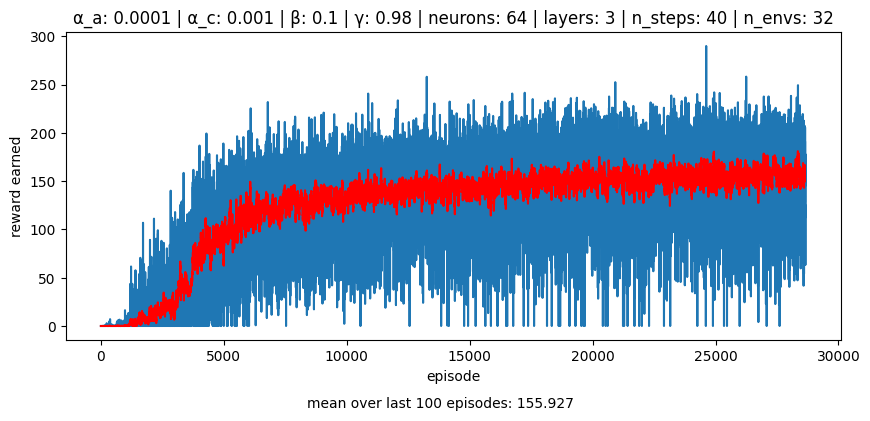

In [550]:
# moving average function:
def moving_average(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'valid')

filtered_data = moving_average(reward_history, 20)
last_few = np.mean(reward_history[-100:]).round(3)

figure = plt.figure(figsize = (10, 4))
plt.plot(reward_history)
plt.plot(filtered_data, 'r-')
plt.minorticks_on
plt.title(f"α_a: {lr_a} | α_c: {lr_c} | β: {beta} | γ: {gamma} | neurons: {neurons} | layers: {layers} | n_steps: {n_steps} | n_envs: {n_envs}")
plt.xlabel('episode')
plt.ylabel(f'reward earned')
plt.figtext(x = 0.5, y = -0.05, s = f"mean over last {100} episodes: {last_few}", ha = 'center', va = 'center')

old stuff:

In [551]:
# # define values:
# n_steps = 5
# training_length = 1000
# beta = 0.01
# reward_history = []

# # training algorithm:
# for episode in tqdm(range(training_length), colour = "#33FF00", ncols = 100, desc = "training progress:"):
#     # 0) initialization:
#     # reset all environments:
#     obs, _ = envs.reset()
#     episode_reward = 0
#     done = False

#     # clear buffers:
#     obs_buf = []
#     act_buf = []
#     rew_buf = []
#     val_buf = []
#     done_buf = []

#     # 1) rollout for n_steps:
#     for step in range(n_steps):
#         # a) pass observation through networks:
#         obs_tensor = tf.convert_to_tensor(obs, dtype = tf.float32)
#         actor_output = actor(obs_tensor)
#         critic_output = critic(obs_tensor)

#         # b) pick an action:
#         actions = tf.random.categorical(actor_output, 1)[:, 0].numpy()

#         # c) step the environments:
#         next_obs, rewards, terms, truncs, _ = envs.step(actions)
#         done = np.logical_or(terms, truncs)

#         # d) populate buffers:
#         obs_buf.append(obs)
#         act_buf.append(actions)
#         rew_buf.append(rewards)
#         val_buf.append(critic_output.numpy().squeeze())
#         done_buf.append(done)
        
#         # e) advance state:
#         obs = next_obs
    
#     # 2) get the value at the last states:
#     last_values = critic(tf.convert_to_tensor(obs, dtype = tf.float32)).numpy().squeeze()

#     # 3) stack buffers, shape is [n_steps, n_envs, nS]:
#     obs_buf = np.array(obs_buf)
#     act_buf = np.array(act_buf)
#     rew_buf = np.array(rew_buf)
#     val_buf = np.array(val_buf)
#     done_buf = np.array(done_buf)

#     # 4) compute returns and advantages:
#     returns = discounted_returns(rew_buf, done_buf, last_values)
#     advantages = returns - val_buf

#     # 5) flatten, merging across steps and environments:
#     flat_obs = obs_buf.reshape(-1, nS)
#     flat_act = act_buf.reshape(-1)
#     flat_ret = returns.reshape(-1)
#     flat_adv = advantages.reshape(-1)

#     # 6) perform the training step:
#     training_step(flat_obs, flat_act, flat_ret, flat_adv)

#     # 7) compute episodic reward:
#     avg_reward = np.mean([np.sum(rew_buf[:, i]) for i in range(n_envs)])
#     reward_history.append(avg_reward)
